In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
from typing import List, Dict, Union



def open_gff3_files(path:str= '') -> List[List[str]]:
    '''
    Opens and reads a GFF3 file and returns its contents as a list of lists.

    Parameters:
    -----------
    path: str
        The path to the GFF3 file.

    Returns:
    --------
    List[List[str]]
        A list of lists containing the contents of the GFF3 file.
    '''
    with open(path, 'r') as infile:
        LINES = []
        for line in infile:
            LINES.append(line[:].split('\t'))
        LINES = LINES[1:]
    
    return LINES



def tidy_up_gff(lst_of_gff:list) -> list:
    """
    This function takes a list of GFF lines and returns a list of dictionaries,
    with each dictionary containing information on the signal peptides in the GFF file.
    
    Parameters:
    lst_of_gff (list): A list of GFF lines.
    
    Returns:
    list_of_peptides (list): A list of dictionaries, with each dictionary containing information on the signal peptides in the GFF file.
    """
    signal_peptides = {}
    list_of_peptides = []

    for peptide in lst_of_gff:
        signal_peptides['gene'] = peptide[0][:19]
        signal_peptides['start_pos'] = int(peptide[3])
        signal_peptides['end_pos']= int(peptide[4]) # We want to get the last AA downstream from the cleavage
        signal_peptides['signal_peptide_likelyhood']= peptide[5]
        list_of_peptides.append(signal_peptides)
        signal_peptides = {'gene':'', 'start_pos':'', 'end_pos':'','signal_peptide_likelyhood': '' }

    return list_of_peptides




def dict_of_signal_peptides(path: str = '') -> List[Dict[str, Union[str, int]]]:
    """
    Given a path to a GFF3 file, returns a list of dictionaries with information on signal peptides.

    Args:
        path (str): Path to the GFF3 file. Default is an empty string.

    Returns:
        list: A list of dictionaries where each dictionary contains the following keys:
            - 'gene' (str): Gene name of the signal peptide.
            - 'start_pos' (int): Start position of the signal peptide in the protein sequence.
            - 'end_pos' (int): End position of the signal peptide in the protein sequence.
            - 'signal_peptide_likelyhood' (str): The likelihood of the sequence being a signal peptide.
    """
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    return dict_of_signal_peptides


def read_gff_to_pd(path:str= '') -> pd.DataFrame:
    """
    Reads a GFF3 file and returns a pandas DataFrame with columns 'gene', 'start_pos', 'end_pos', 
    and 'signal_peptide_likelyhood'.
    
    Parameters:
    -----------
    path : str
        The path to the GFF3 file.
        
    Returns:
    --------
    df : pandas.DataFrame
        A DataFrame with columns 'gene', 'start_pos', 'end_pos', and 'signal_peptide_likelyhood'.
    """
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df



def get_signal_peptides_cross_ref_with_genome(list_of_peptides: List[dict], all_proteins: List[SeqRecord]) -> List[SeqRecord]:
    """
    Extracts the protein sequence that corresponds to each predicted signal peptide sequence from the input list
    of peptides and matches the signal peptide to its corresponding protein sequence in the input list of 
    protein sequences.
    
    Parameters
    ----------
    list_of_peptides : list
        A list of dictionaries containing information about predicted signal peptide sequences, including gene name, 
        start and end positions, and the signal peptide likelihood score.
    all_proteins : list
        A list of SeqRecord objects containing protein sequences.
    
    Returns
    -------
    list
        A list of SeqRecord objects that correspond to the input predicted signal peptide sequences, including 
        protein sequence, ID, name, and a description indicating that the sequence corresponds to a predicted 
        signal peptide.
    """
    signal_peptide_seqs = []

    for signal_peptide in list_of_peptides:
        for seqrecord in all_proteins:
            if signal_peptide['gene'] in seqrecord.id:             
                seq = SeqRecord(
                    Seq(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]), 
                    id=seqrecord.id,
                    name=seqrecord.name,
                    description="signal_peptide predicted by signalP")

                signal_peptide_seqs.append(seq)

    return signal_peptide_seqs


def add_dunder_tail(peptide:str , max_lenght:int=22 ): 
    '''Adds a tail if a peptide is shorter than the specified max_len.
    '''
    if len(peptide) < max_lenght: 
        difference = max_lenght - len(peptide)
        sequence = peptide + ('-'*difference)
    else: 
        sequence = peptide
        
    return sequence     


# 01_SignalP_analysis

## Introduction
The objective of this project is to analyze the signal peptides of the A.oryzae genome. The first step is to download the genome and partition it into 5000 bits. These bits will then be uploaded to SignalP, a tool for predicting signal peptides. The program will retrieve the signal peptides from SignalP and perform an analysis of different regions. Finally, the project will create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

### Objective: 


- Download the A.oryzae genome
- Partition the genome into 5000 bits
- Upload the partitioned genome to SignalP
- Retrieve signal peptides from the SignalP analysis
- Analyze different regions of the signal peptides
- Create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

In [2]:
from teemi.design.fetch_sequences import read_fasta_files

## Synthetic signal peptides

In [3]:
synthetic_sps_secretogen = pd.read_csv('../data/15_SecretoGen/Best_signal_peptides_for_A_oryzae_RFP_his_tag_sorted.csv')

In [4]:
synthetic_sps_secretogen =  synthetic_sps_secretogen.rename(columns = {'Unnamed: 0':'gene','Sequence':'secretogen_sequence' })
synthetic_sps_secretogen

,SP_ID,secretogen_sequence,Perplexity
0,SP_997,MRPTLLALGVISFALTLHS,7.515804
1,SP_944,MKFTLIILIIVILTIIFSPGALA,7.421489
2,SP_948,MKVTLSLLAVFLAALSASAIPANG,7.179219
3,SP_993,MKAIIILLLIILTLALTVQG,7.140379
4,SP_204,MRVFSATAILALSPLLIASASP,6.925975
...,...,...,...
995,SP_656,MVLGILTITAIPTVTGLANA,1.597785
996,SP_696,MVLGLLTIAAIPTVTGVAQA,1.563614
997,SP_757,MVLGLLTIAAIPTVTGVGNAVSA,1.554127
998,SP_253,MVLGILTITAIPTVTGVAQA,1.535361


In [5]:
print(len('MRPTLLALGVISFALTLHS'))

19


In [6]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO


In [8]:
rfp = Seq('ASSEDVIKEFMRFKVRMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFQYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASTERMYPEDGALKGEIKMRLKLKDGGHYDAEVKTTYMAKKPVQLPGAYKTDIKLDITSHNEDYTIVEQYERAEGRHSTGAHHHHHH')

Sps = []
for index, row in synthetic_sps_secretogen.iterrows():
    SP = SeqRecord(Seq(row['secretogen_sequence'] +rfp), name = str(row['SP_ID']), id = str(row['SP_ID']), description= '')
    Sps.append(SP)

len(Sps)

1000

In [9]:
print(Sps[0].format('fasta'))

>SP_997
MRPTLLALGVISFALTLHSASSEDVIKEFMRFKVRMEGSVNGHEFEIEGEGEGRPYEGTQ
TAKLKVTKGGPLPFAWDILSPQFQYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDG
GVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASTERMYPEDGALKGEIK
MRLKLKDGGHYDAEVKTTYMAKKPVQLPGAYKTDIKLDITSHNEDYTIVEQYERAEGRHS
TGAHHHHHH



In [10]:

# Write to a FASTA file
with open('../data/15_SecretoGen/best_only_sps_1000_300724.fasta', 'w') as output_file:
    SeqIO.write(Sps, output_file, 'fasta')

# Confirm the number of sequences written
len(Sps)

1000

### Running signalP 6.0 with eukaryoter l

In [11]:

synthetic_sps = read_gff_to_pd('../data/15_SecretoGen/output_all_results_synthetic_sps_300724/output.gff3')
synthetic_sps['SP_ID'] = synthetic_sps['gene'].apply(lambda x: f'SP_{x}')

synthetic_sps

,gene,start_pos,end_pos,signal_peptide_likelyhood,SP_ID
0,997,1,22,0.9998568,SP_997
1,944,1,23,0.9998217,SP_944
2,948,1,19,0.9998606,SP_948
3,993,1,23,0.99985224,SP_993
4,204,1,25,0.9998476,SP_204
...,...,...,...,...,...
994,656,1,20,0.9998165,SP_656
995,696,1,20,0.99981046,SP_696
996,757,1,23,0.8331868,SP_757
997,253,1,20,0.99983555,SP_253


Apparently SignalP makes different predictions to the peptide lenght so we fetfch it from the signalP predictions.

In [12]:

# Create a new list to hold the extracted sequences
extracted_sequences = []

# Iterate through the dataframe
for index, row in synthetic_sps.iterrows():
    sp_id = row['SP_ID']
    start_pos = row['start_pos'] - 1  # Convert to zero-based index
    end_pos = row['end_pos']
    
    # Find the corresponding Dseqrecord by SP_ID
    for record in Sps:
        if record.id == sp_id:
            # Extract the sequence from start_pos to end_pos
            extracted_seq = record.seq[start_pos:end_pos]
            extracted_sequences.append(str(extracted_seq))
len(extracted_sequences[0])

22

In [13]:
# update synthetic_sps from SIGNALP 
synthetic_sps['sequence'] = extracted_sequences

Lets get the differenct regions of the signal peptides: 

##  Regions of Signal peptides

In [14]:
synthetic_sps_regions = read_gff_to_pd('../data/15_SecretoGen/output_all_results_synthetic_sps_300724/region_output.gff3')
synthetic_sps_regions['SP_ID'] = synthetic_sps_regions['gene'].apply(lambda x: f'SP_{x}')

synthetic_sps_regions

,gene,start_pos,end_pos,signal_peptide_likelyhood,SP_ID
0,997,1,2,.,SP_997
1,997,3,17,.,SP_997
2,997,18,22,.,SP_997
3,944,1,2,.,SP_944
4,944,3,17,.,SP_944
...,...,...,...,...,...
2992,253,3,14,.,SP_253
2993,253,15,20,.,SP_253
2994,13,1,2,.,SP_13
2995,13,3,14,.,SP_13


In [15]:
synthetic_sps_regions.columns = ['gene',	'start_pos_region','end_pos_region','region','SP_ID']
synthetic_sps_regions

,gene,start_pos_region,end_pos_region,region,SP_ID
0,997,1,2,.,SP_997
1,997,3,17,.,SP_997
2,997,18,22,.,SP_997
3,944,1,2,.,SP_944
4,944,3,17,.,SP_944
...,...,...,...,...,...
2992,253,3,14,.,SP_253
2993,253,15,20,.,SP_253
2994,13,1,2,.,SP_13
2995,13,3,14,.,SP_13


In [16]:
# every region is the same N, H, C. will just append a long list 
regions = ['n-region', 'h-region', 'c-region']* int((len(synthetic_sps_regions)/3))
synthetic_sps_regions['region'] = regions

## Merge all dfs

In [18]:
# Ensure 'gene' columns are of the same type
synthetic_sps['SP_ID'] = synthetic_sps['SP_ID'].astype(str)
synthetic_sps_regions['SP_ID'] = synthetic_sps_regions['SP_ID'].astype(str)
synthetic_sps_secretogen['SP_ID'] = synthetic_sps_secretogen['SP_ID'].astype(str)

# Merge the dataframes
merged_df = pd.merge(synthetic_sps, synthetic_sps_regions, how='outer', on='SP_ID')
merged_df = pd.merge(merged_df, synthetic_sps_secretogen, how='outer', on='SP_ID')
merged = merged_df.dropna()
merged

,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity
0,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,1.0,2.0,n-region,MRPTLLALGVISFALTLHS,7.515804
1,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,3.0,17.0,h-region,MRPTLLALGVISFALTLHS,7.515804
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804
3,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,1.0,2.0,n-region,MKFTLIILIIVILTIIFSPGALA,7.421489
4,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,3.0,17.0,h-region,MKFTLIILIIVILTIIFSPGALA,7.421489
...,...,...,...,...,...,...,...,...,...,...,...,...
2992,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,3.0,14.0,h-region,MVLGILTITAIPTVTGVAQA,1.535361
2993,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,15.0,20.0,c-region,MVLGILTITAIPTVTGVAQA,1.535361
2994,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,1.0,2.0,n-region,MVLGILTITAIPTVTGVANA,1.530345
2995,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,3.0,14.0,h-region,MVLGILTITAIPTVTGVANA,1.530345


In [19]:


# Define the column you want to update
target_column = 'start_pos_region'

# Add 2 to non-zero cells in the target column - BECAUSE this function was meant to only add the last aa from the SignalP output for the pure signal peptides
#merged.loc[merged[target_column] != 0, target_column] += 1


# Define the column you want to update
target_column = 'end_pos_region'

# Add 2 to non-zero cells in the target column - BECAUSE this function was meant to only add the last aa from the SignalP output for the pure signal peptides
#merged.loc[merged[target_column] != 0, target_column] += -1


# We can get relative lenght like this: 
merged['relative_length'] = merged['end_pos_region'] - merged['start_pos_region']


merged

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/3092869735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['relative_length'] = merged['end_pos_region'] - merged['start_pos_region']


,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity,relative_length
0,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,1.0,2.0,n-region,MRPTLLALGVISFALTLHS,7.515804,1.0
1,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,3.0,17.0,h-region,MRPTLLALGVISFALTLHS,7.515804,14.0
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804,4.0
3,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,1.0,2.0,n-region,MKFTLIILIIVILTIIFSPGALA,7.421489,1.0
4,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,3.0,17.0,h-region,MKFTLIILIIVILTIIFSPGALA,7.421489,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,3.0,14.0,h-region,MVLGILTITAIPTVTGVAQA,1.535361,11.0
2993,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,15.0,20.0,c-region,MVLGILTITAIPTVTGVAQA,1.535361,5.0
2994,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,1.0,2.0,n-region,MVLGILTITAIPTVTGVANA,1.530345,1.0
2995,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,3.0,14.0,h-region,MVLGILTITAIPTVTGVANA,1.530345,11.0


Lets get the sequences from the dataframe above. Make sure that that we start from the correct position. 

In [20]:
# initite empty column
merged['region_seq'] = ''

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/3133509826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['region_seq'] = ''


In [21]:
# initite empty column
merged['region_seq'] = ''

list_of_seqs = []
for index, row in merged.iterrows():
    if row['start_pos_region'] == 1: 
        start = int(row['start_pos_region'])-1
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop])
    else: 
        start = int(row['start_pos_region'])-1
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop]) 
    
merged['region_seq'] = list_of_seqs

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/2294408263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['region_seq'] = ''
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/2294408263.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['region_seq'] = list_of_seqs


In [22]:
merged.head(10)

,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity,relative_length,region_seq
0,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,1.0,2.0,n-region,MRPTLLALGVISFALTLHS,7.515804,1.0,MR
1,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,3.0,17.0,h-region,MRPTLLALGVISFALTLHS,7.515804,14.0,PTLLALGVISFALTL
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804,4.0,HSASS
3,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,1.0,2.0,n-region,MKFTLIILIIVILTIIFSPGALA,7.421489,1.0,MK
4,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,3.0,17.0,h-region,MKFTLIILIIVILTIIFSPGALA,7.421489,14.0,FTLIILIIVILTIIF
5,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,18.0,23.0,c-region,MKFTLIILIIVILTIIFSPGALA,7.421489,5.0,SPGALA
6,948,1.0,19.0,0.9998606,SP_948,MKVTLSLLAVFLAALSASA,948,1.0,2.0,n-region,MKVTLSLLAVFLAALSASAIPANG,7.179219,1.0,MK
7,948,1.0,19.0,0.9998606,SP_948,MKVTLSLLAVFLAALSASA,948,3.0,15.0,h-region,MKVTLSLLAVFLAALSASAIPANG,7.179219,12.0,VTLSLLAVFLAAL
8,948,1.0,19.0,0.9998606,SP_948,MKVTLSLLAVFLAALSASA,948,16.0,19.0,c-region,MKVTLSLLAVFLAALSASAIPANG,7.179219,3.0,SASA
9,993,1.0,23.0,0.99985224,SP_993,MKAIIILLLIILTLALTVQGASS,993,1.0,2.0,n-region,MKAIIILLLIILTLALTVQG,7.140379,1.0,MK


In [23]:
merged.to_clipboard()

### Biochemical analysis

In [24]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np

list_of_kyle_d = []
isoelectric_point =[]
charge = []

for index, row in merged.iterrows():
    try:
        sequence = str(row['region_seq'])
        if len(sequence) == 0:
            raise ValueError("Empty sequence")
        protein = ProteinAnalysis(sequence)
        list_of_kyle_d.append(protein.gravy())
        charge.append(protein.charge_at_pH(7.6))
    except (ValueError, ZeroDivisionError) as e:
        print(f'Error processing row {index}: {e}')
        list_of_kyle_d.append(np.nan)  # or None
        charge.append(np.nan)  # or None

merged['kd_hydrophobicity'] = list_of_kyle_d
merged['charge_at_ph7'] = charge


merged


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/3067542112.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['kd_hydrophobicity'] = list_of_kyle_d
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_85678/3067542112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['charge_at_ph7'] = charge


,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity,relative_length,region_seq,kd_hydrophobicity,charge_at_ph7
0,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,1.0,2.0,n-region,MRPTLLALGVISFALTLHS,7.515804,1.0,MR,-1.300000,0.200809
1,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,3.0,17.0,h-region,MRPTLLALGVISFALTLHS,7.515804,14.0,PTLLALGVISFALTL,1.993333,-0.147963
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804,4.0,HSASS,-0.760000,-0.533796
3,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,1.0,2.0,n-region,MKFTLIILIIVILTIIFSPGALA,7.421489,1.0,MK,-1.000000,0.196884
4,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,3.0,17.0,h-region,MKFTLIILIIVILTIIFSPGALA,7.421489,14.0,FTLIILIIVILTIIF,3.420000,-0.557223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,3.0,14.0,h-region,MVLGILTITAIPTVTGVAQA,1.535361,11.0,LGILTITAIPTV,1.916667,-0.557223
2993,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,15.0,20.0,c-region,MVLGILTITAIPTVTGVAQA,1.535361,5.0,TGVAQA,0.533333,-0.857574
2994,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,1.0,2.0,n-region,MVLGILTITAIPTVTGVANA,1.530345,1.0,MV,3.050000,-0.799151
2995,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,3.0,14.0,h-region,MVLGILTITAIPTVTGVANA,1.530345,11.0,LGILTITAIPTV,1.916667,-0.557223


In [25]:
merged

,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity,relative_length,region_seq,kd_hydrophobicity,charge_at_ph7
0,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,1.0,2.0,n-region,MRPTLLALGVISFALTLHS,7.515804,1.0,MR,-1.300000,0.200809
1,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,3.0,17.0,h-region,MRPTLLALGVISFALTLHS,7.515804,14.0,PTLLALGVISFALTL,1.993333,-0.147963
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804,4.0,HSASS,-0.760000,-0.533796
3,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,1.0,2.0,n-region,MKFTLIILIIVILTIIFSPGALA,7.421489,1.0,MK,-1.000000,0.196884
4,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,3.0,17.0,h-region,MKFTLIILIIVILTIIFSPGALA,7.421489,14.0,FTLIILIIVILTIIF,3.420000,-0.557223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,3.0,14.0,h-region,MVLGILTITAIPTVTGVAQA,1.535361,11.0,LGILTITAIPTV,1.916667,-0.557223
2993,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,15.0,20.0,c-region,MVLGILTITAIPTVTGVAQA,1.535361,5.0,TGVAQA,0.533333,-0.857574
2994,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,1.0,2.0,n-region,MVLGILTITAIPTVTGVANA,1.530345,1.0,MV,3.050000,-0.799151
2995,13,1.0,20.0,0.9998073,SP_13,MVLGILTITAIPTVTGVANA,13,3.0,14.0,h-region,MVLGILTITAIPTVTGVANA,1.530345,11.0,LGILTITAIPTV,1.916667,-0.557223


#### Grouping the regions 

In [26]:
n_region = merged.groupby("region")
n_region = n_region.get_group('n-region')

h_region = merged.groupby("region")
h_region = h_region.get_group('h-region')

c_region = merged.groupby("region")
c_region = c_region.get_group('c-region')

In [27]:
c_region

,gene_x,start_pos,end_pos,signal_peptide_likelyhood,SP_ID,sequence,gene_y,start_pos_region,end_pos_region,region,secretogen_sequence,Perplexity,relative_length,region_seq,kd_hydrophobicity,charge_at_ph7
2,997,1.0,22.0,0.9998568,SP_997,MRPTLLALGVISFALTLHSASS,997,18.0,22.0,c-region,MRPTLLALGVISFALTLHS,7.515804,4.0,HSASS,-0.760000,-0.533796
5,944,1.0,23.0,0.9998217,SP_944,MKFTLIILIIVILTIIFSPGALA,944,18.0,23.0,c-region,MKFTLIILIIVILTIIFSPGALA,7.421489,5.0,SPGALA,0.766667,-0.823772
8,948,1.0,19.0,0.9998606,SP_948,MKVTLSLLAVFLAALSASA,948,16.0,19.0,c-region,MKVTLSLLAVFLAALSASAIPANG,7.179219,3.0,SASA,0.500000,-0.823772
11,993,1.0,23.0,0.99985224,SP_993,MKAIIILLLIILTLALTVQGASS,993,18.0,23.0,c-region,MKAIIILLLIILTLALTVQG,7.140379,5.0,VQGASS,0.083333,-0.590986
14,204,1.0,25.0,0.9998476,SP_204,MRVFSATAILALSPLLIASASPASS,204,19.0,25.0,c-region,MRVFSATAILALSPLLIASASP,6.925975,6.0,SASPASS,-0.171429,-0.823772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,656,1.0,20.0,0.9998165,SP_656,MVLGILTITAIPTVTGLANA,656,15.0,20.0,c-region,MVLGILTITAIPTVTGLANA,1.597785,5.0,TGLANA,0.466667,-0.857574
2987,696,1.0,20.0,0.99981046,SP_696,MVLGLLTIAAIPTVTGVAQA,696,15.0,20.0,c-region,MVLGLLTIAAIPTVTGVAQA,1.563614,5.0,TGVAQA,0.533333,-0.857574
2990,757,1.0,23.0,0.8331868,SP_757,MVLGLLTIAAIPTVTGVGNAVSA,757,15.0,23.0,c-region,MVLGLLTIAAIPTVTGVGNAVSA,1.554127,8.0,TGVGNAVSA,0.688889,-0.857574
2993,253,1.0,20.0,0.99983555,SP_253,MVLGILTITAIPTVTGVAQA,253,15.0,20.0,c-region,MVLGILTITAIPTVTGVAQA,1.535361,5.0,TGVAQA,0.533333,-0.857574


### Plotting hydrophicity per regions

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

### Plotting charge_at_ph 7.6 per regions
The following article mentions that physiological ph is 7.6 for Aspergillus
ref : https://pubmed.ncbi.nlm.nih.gov/12135488/

## Plotting the relative length of each region


### Merged plots


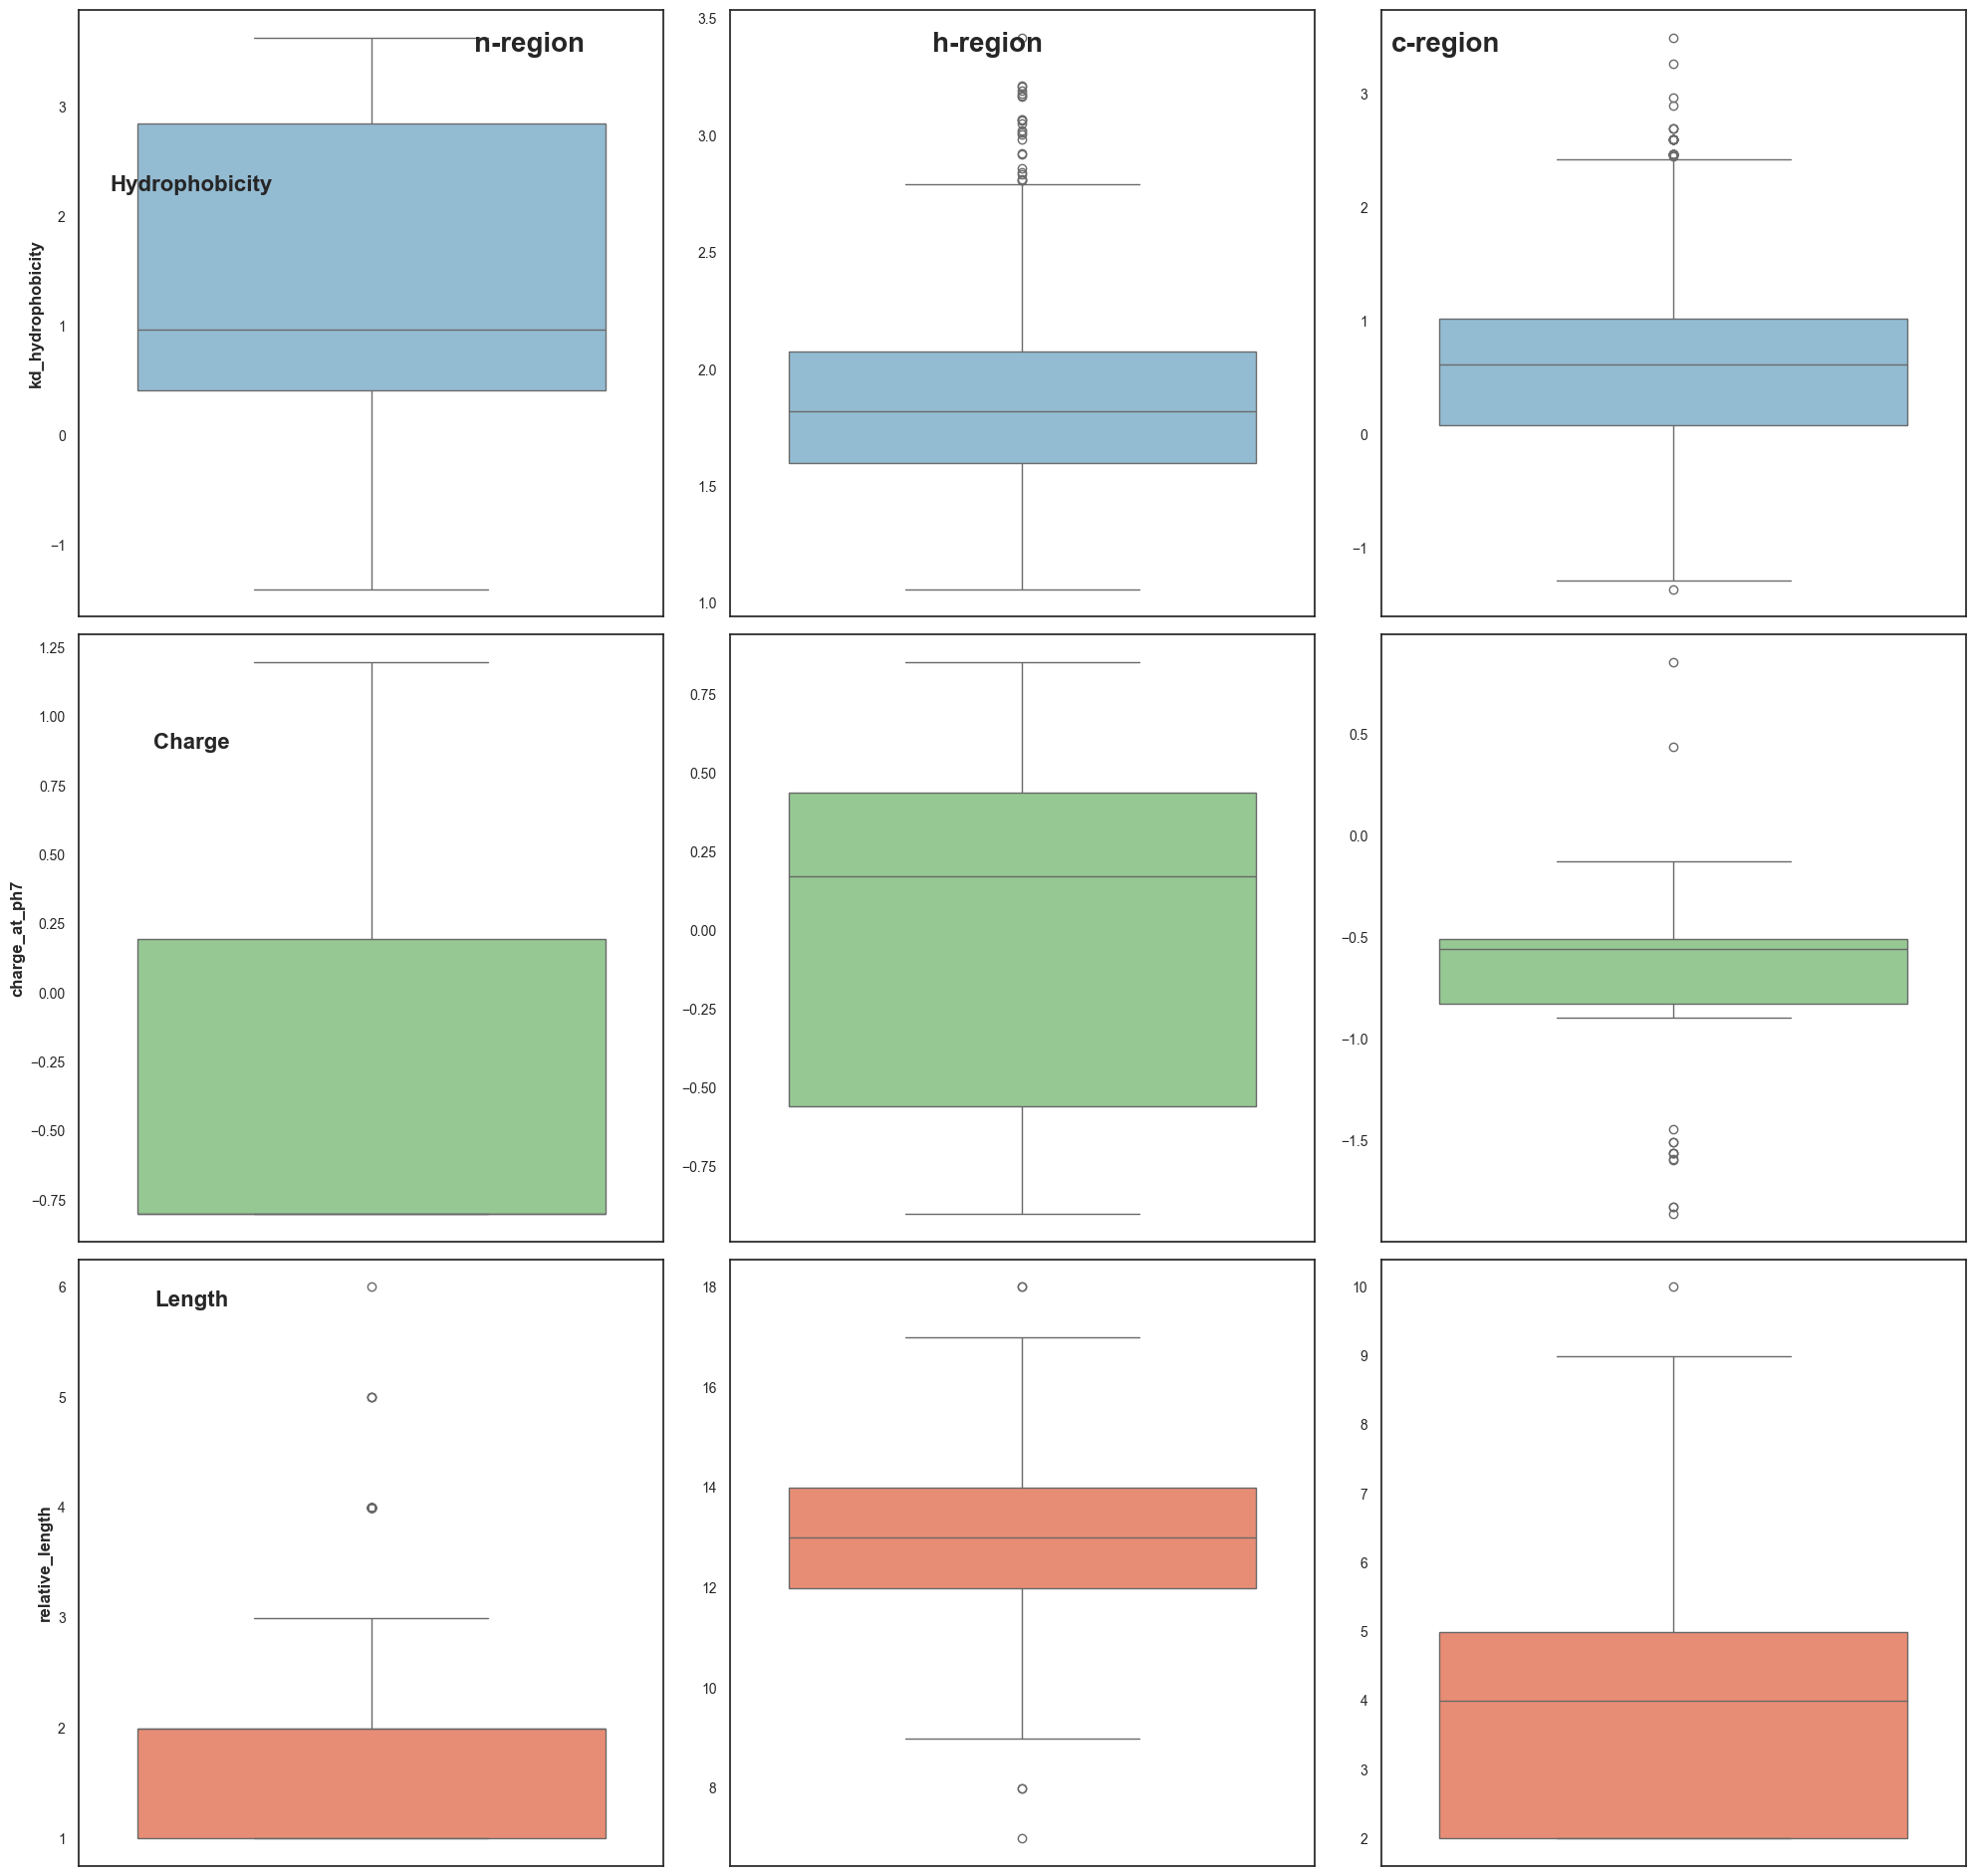

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set font settings
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

# Set seaborn style to 'white' or 'ticks' for no grid
sns.set(style='white')

# Custom color palettes for each row
color_palettes = ['Blues', 'Greens', 'Reds']

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Define properties and regions for iteration
properties = ['kd_hydrophobicity', 'charge_at_ph7', 'relative_length']
regions = [n_region, h_region, c_region]
region_names = ['n-region', 'h-region', 'c-region']

# Creating subplots with distinct colors
for i, prop in enumerate(properties):
    palette = sns.color_palette(color_palettes[i])
    for j, region in enumerate(regions):
        ax = plt.subplot(3, 3, i * 3 + j + 1)
        sns.boxplot(y=region[prop], orient='vertical', ax=ax, color=palette[2])  # Using a specific color from the palette
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=10, labelrotation=0)
        
        # Only show y-axis labels for the leftmost plots
        if j == 0:
            ax.set_ylabel(prop, fontsize=12, fontweight='bold')

# Large Vertical Titles for Regions
plt.figtext(0.27, 0.92, 'n-region', ha='center', fontsize=20, fontweight='bold')
plt.figtext(0.5, 0.92, 'h-region', ha='center', fontsize=20, fontweight='bold')
plt.figtext(0.73, 0.92, 'c-region', ha='center', fontsize=20, fontweight='bold')

# Large Horizontal Labels for Properties
plt.figtext(0.1, 0.85, 'Hydrophobicity', ha='center', fontsize=16, fontweight='bold')
plt.figtext(0.1, 0.57, 'Charge', ha='center', fontsize=16, fontweight='bold')
plt.figtext(0.1, 0.29, 'Length', ha='center', fontsize=16, fontweight='bold')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a file (optional)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()


## Merging all the biochemistry together

In [32]:
import pandas as pd

# Assuming n_region, h_region, and c_region are your DataFrames

# For n-region
n_region_rename_dict = {col: 'n_' + col for col in ['relative_length', 'region_seq', 'kd_hydrophobicity', 'charge_at_ph7']}
n_region = n_region.rename(columns=n_region_rename_dict)

# For h-region
h_region_rename_dict = {col: 'h_' + col for col in ['relative_length', 'region_seq', 'kd_hydrophobicity', 'charge_at_ph7']}
h_region = h_region.rename(columns=h_region_rename_dict)

# For c-region
c_region_rename_dict = {col: 'c_' + col for col in ['relative_length', 'region_seq', 'kd_hydrophobicity', 'charge_at_ph7']}
c_region = c_region.rename(columns=c_region_rename_dict)

# Assuming gene is the primary key and is unique for each row
# Merging the regions on the gene column
merged = n_region.merge(h_region, on='SP_ID').merge(c_region, on='SP_ID')

# Columns needed
col_needed_bioechem = ['SP_ID', 'n_relative_length', 'n_kd_hydrophobicity', 'n_charge_at_ph7',
                       'h_relative_length', 'h_kd_hydrophobicity', 'h_charge_at_ph7',
                       'c_relative_length', 'c_kd_hydrophobicity', 'c_charge_at_ph7']

biochemical_result = merged[col_needed_bioechem]


# Print biochemical_result
biochemical_result


,SP_ID,n_relative_length,n_kd_hydrophobicity,n_charge_at_ph7,h_relative_length,h_kd_hydrophobicity,h_charge_at_ph7,c_relative_length,c_kd_hydrophobicity,c_charge_at_ph7
0,SP_997,1.0,-1.30,0.200809,14.0,1.993333,-0.147963,4.0,-0.760000,-0.533796
1,SP_944,1.0,-1.00,0.196884,14.0,3.420000,-0.557223,5.0,0.766667,-0.823772
2,SP_948,1.0,-1.00,0.196884,12.0,2.623077,-0.590986,3.0,0.500000,-0.823772
3,SP_993,1.0,-1.00,0.196884,14.0,3.166667,-0.505667,5.0,0.083333,-0.590986
4,SP_204,1.0,-1.30,0.200809,15.0,2.156250,-0.590986,6.0,-0.171429,-0.823772
...,...,...,...,...,...,...,...,...,...,...
994,SP_656,1.0,3.05,-0.799151,11.0,1.916667,-0.557223,5.0,0.466667,-0.857574
995,SP_696,1.0,3.05,-0.799151,11.0,2.066667,-0.557223,5.0,0.533333,-0.857574
996,SP_757,1.0,3.05,-0.799151,11.0,2.066667,-0.557223,8.0,0.688889,-0.857574
997,SP_253,1.0,3.05,-0.799151,11.0,1.916667,-0.557223,5.0,0.533333,-0.857574


In [33]:
biochemical_result.to_csv('../data/02_all_signal_peptides/biochemical_results_synthetic_signalpeptides.csv', index=False)